In [1]:
#reload the modules before running the program
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy import signal
from scipy.fft import fftshift
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import math
import cv2

In [2]:
from datasets import RFData, CameraData, SignalDataset, FuseDatasets
import metrics
import utils

In [73]:
np.random.seed(0)
torch.manual_seed(0)
data_path = r"D:\osa_new_processed"
# trial_folders = ["v_12_5", "v_13_5", "v_13_10"]
trial_folders = os.listdir(data_path)

# train_idxs = np.linspace(0, 49, 50, dtype=int)
train_folders = trial_folders#[trial_folders[i] for i in train_idxs]
# test_folders = [trial_folders[i] for i in range(len(trial_folders)) if i not in train_idxs]


thermal_file_name = "Thermal_Camera"
num_samps_oversample = 20 # per experiment, number of samples to generate
data_length = 9000
fs = 30
out_len = 1800 # sample length generated
thermal_ext = ".tiff"

dataset_thermal_train = CameraData(data_path, train_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)
# dataset_thermal_test = CameraData(data_path, test_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)

samp_f=5e6
freq_slope=60.012e12
samples_per_chirp=256
num_tx = 3
num_rx = 4
radar_file_name = "FMCW_Radar.npy"
window_size = 5 # number of range bins to use

dataset_radar_train = RFData(data_path, train_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)
# dataset_radar_test = RFData(data_path, test_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)

In [7]:
import pickle
path = r"D:\osa_new_processed\v_13_90\gt_dict.pkl"

with open(path, "rb") as f:
    gt_dict = pickle.load(f)

print(gt_dict.keys())

dict_keys(['Wireless', 'CHEST', 'ABD', 'PTAF', 'AIR_flow', 'OSA', 'CSA', 'MSA', 'Partial_Apnea', 'Hypopnea'])


In [75]:
np.random.seed(0)
torch.manual_seed(0)
vital_dict_file_name = "gt_dict.pkl"
vital_key_radar = "CHEST"
vital_key_thermal = "AIR_flow"
l_freq_bpm = 5
u_freq_bpm = 30
dataset_OSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'OSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_CSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'CSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_hypopnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Hypopnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_partial_apnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Partial_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_gt_thermal_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
dataset_gt_radar_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

# dataset_apnea_test = SignalDataset(data_path, test_folders, vital_dict_file_name, 'Sleep_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
#                               normalize=False)
# dataset_gt_thermal_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
# dataset_gt_radar_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

In [76]:
np.random.seed(0)
torch.manual_seed(0)
fused_dataset_train = FuseDatasets([dataset_radar_train, dataset_thermal_train, dataset_gt_radar_train, dataset_gt_thermal_train, dataset_OSA_train, dataset_CSA_train, dataset_hypopnea_train, dataset_partial_apnea_train], ["radar", "thermal", "gt_radar", "gt_ir", "gt_OSA", "gt_CSA", "hypopnea", "partial_apnea"], out_len=out_len)
# fused_dataset_test = FuseDatasets([dataset_radar_test, dataset_thermal_test, dataset_gt_radar_test, dataset_gt_thermal_test, dataset_apnea_test], ["radar", "thermal", "gt_radar", "gt_ir", "gt_apnea"], out_len=out_len)

In [81]:
save_path = r"K:\OSA_project\Emir_Clean\pre_load_datav2"
gt_OSA = np.zeros((len(fused_dataset_train), 1800))
gt_CSA = np.zeros((len(fused_dataset_train), 1800))
thermal_arr = np.zeros((len(fused_dataset_train), 1800))
gt_hypopnea = np.zeros((len(fused_dataset_train), 1800))
# thermal_vid_arr = np.zeros((len(fused_dataset_train), 1800, 64, 64))
radar_arr = np.zeros((len(fused_dataset_train), 1800, 3, 4, 2, 5))
gt_radar_arr = np.zeros((len(fused_dataset_train), 1800))
gt_ir_arr = np.zeros((len(fused_dataset_train), 1800))

for i in tqdm(range(len(fused_dataset_train))):
    radar_arr[i,:,:,:,:,:] = fused_dataset_train[i]['radar']
    gt_radar_arr[i,:] = fused_dataset_train[i]['gt_radar'][:,0]
    gt_ir_arr[i,:] = fused_dataset_train[i]['gt_ir'][:,0]
    # thermal_vid_arr[i,:,:,:] = fused_dataset_train[i]['thermal'][0,:]
    gt_hypopnea[i,:] = fused_dataset_train[i]["hypopnea"][:,0]
    gt_OSA[i,:] = fused_dataset_train[i]["gt_OSA"][:,0]
    gt_CSA[i,:] = fused_dataset_train[i]["gt_CSA"][:,0]

    thermal = utils.get_thermal(fused_dataset_train[i])
    thermal = (thermal - np.mean(thermal))/np.std(thermal)
    thermal_arr[i,:] = thermal
    
np.save(os.path.join(save_path, r"gt_OSA.npy"), gt_OSA)
np.save(os.path.join(save_path, r"gt_CSA.npy"), gt_CSA)
np.save(os.path.join(save_path, r"thermal_arr.npy"), thermal_arr)
# np.save(os.path.join(save_path, r"thermal_vid_arr.npy"), thermal_vid_arr)
np.save(os.path.join(save_path, r"gt_hypopnea.npy"), gt_hypopnea)
np.save(os.path.join(save_path, r"radar_arr.npy"), radar_arr)
np.save(os.path.join(save_path, r"gt_radar_arr.npy"), gt_radar_arr)
np.save(os.path.join(save_path, r"gt_ir_arr.npy"), gt_ir_arr)

100%|██████████| 5200/5200 [7:51:25<00:00,  5.44s/it]   


In [85]:
thermal_vid_arr = np.zeros((len(fused_dataset_train), 1800, 64, 64))
for i in tqdm(range(len(fused_dataset_train))):
    thermal_vid_arr[i,:,:,:] = fused_dataset_train[i]['thermal'][0,:]
np.save(os.path.join(save_path, r"thermal_vid_arr.npy"), thermal_vid_arr)

MemoryError: Unable to allocate 143. GiB for an array with shape (2600, 1800, 64, 64) and data type float64

In [ ]:
NUKS_idx = []
movement_idx = []
mode_lock_idx = []
for i in tqdm(range(len(fused_dataset_train))):
    thermal = thermal_arr[i]
    if(utils.detect_NUKS(thermal) == True):
        NUKS_idx.append(i)
    elif((thermal_vid_arr[i,0,:,:] == thermal_vid_arr[i,0,0,0]).all() == True):
        mode_lock_idx.append(i)
    elif(utils.detect_movement(thermal) == True):
        movement_idx.append(i)

In [ ]:
save_path = r"K:\OSA_project\Emir_Clean\save_idx_arrsv2"
np.save(os.path.join(save_path, r"NUKS_idx.npy"), NUKS_idx)
np.save(os.path.join(save_path, r"movement_idx.npy"), movement_idx)
np.save(os.path.join(save_path, r"mode_lock_idx.npy"), mode_lock_idx)

In [ ]:
full_arr = []
prod_arr = []

th_arr = #np.linspace(0.1, 0.4, 15)
window_size_arr = np.linspace(20,40, 10, dtype=int)
modes = ['90th', 'max', 'median', 'mean']
percentile = 50
t_arr = np.linspace(0, 1800/30, 1800)

for th in tqdm(th_arr):
    for window_max in tqdm(window_size_arr):
        for window_min in window_size_arr:
            for mode in modes:
                gt_arr = []
                pred_arr = []
                

                for idx in np.linspace(0,len(fused_dataset_train)-1,len(fused_dataset_train), dtype=int):
                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in discard_idx)):
                        pred = utils.predict(thermal_arr[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, percentage=percentile, plot=False)

                        gt = gt_apnea[idx]
                        # gt_hp = gt_hypopnea[idx]

                        if((np.mean(gt) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        
                        if(np.mean(pred) > 0.1):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)
                        
                        # if(gt_arr[-1] != pred_arr[-1]):
                        #     print(idx)
                
                        # AHI_arr.append(np.sum(pred_arr) / (1/60))
                        # gt_AHI_arr.append(np.sum(gt_arr) / (1/60))

                precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
                # print("Precision: ", precision, "Recall: ", recall, "Accuracy: ", accuracy, "Confusion Matrix: ", confusion_matrix)
                
                prod_arr.append(precision*recall)
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))

In [77]:
apnea_idx = []
folds = []
count = 0
for i in range(len(dataset_OSA_train)):
    # print(i)
    try:
        # folds.append(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        batch = dataset_OSA_train.__getitem__(i)[:,0]
        if(np.mean(batch) > 0.1):
            apnea_idx.append(i)
    except:
        print(dataset_OSA_train.oversampling_idxs[i][0])
        # print(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        count = count + 1
        pass

print(100*len(apnea_idx)/len(dataset_OSA_train))
print(count)

0.8269230769230769
0


In [57]:
len(apnea_idx)

51

False
False
True


<Figure size 864x864 with 0 Axes>

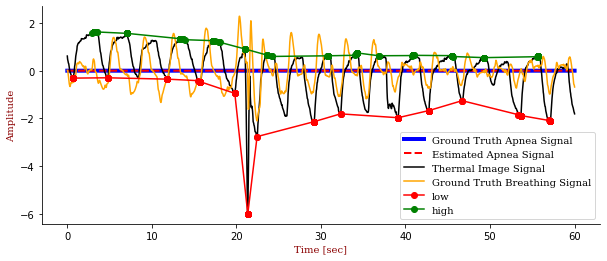

In [7]:
idx = 599
thermal = utils.get_thermal(fused_dataset_train[idx], order=5)
thermal = (thermal - np.mean(thermal))/np.std(thermal)
t_arr = np.linspace(0, len(thermal)/30, len(thermal))
lmin, lmax = utils.hl_envelopes_idx(thermal, dmin=30, dmax=20)
max_th = np.interp(t_arr, t_arr[lmax], thermal[lmax])
min_th = np.interp(t_arr, t_arr[lmin], thermal[lmin])
pred = ((max_th - min_th)/max(max_th - min_th) < 0.2).astype(int)
gt = fused_dataset_train[idx]["gt_apnea"][:,0]


plt.figure(figsize=(12, 12))
# pred[len(pred)-60:] = 0
utils.plot_classification_waveforms(t_arr, thermal, gt, pred, fused_dataset_train[idx]["gt_radar"][:,0])
fused_dataset_train[idx]["hypopnea"][:,0].shape, fused_dataset_train[idx]["partial_apnea"][:,0].shape

print(utils.detect_NUKS(thermal))
print(utils.detect_mode_lock(fused_dataset_train, idx))
utils.plot_envelope(t_arr, thermal, lmin, lmax)
plt.legend(loc='best')

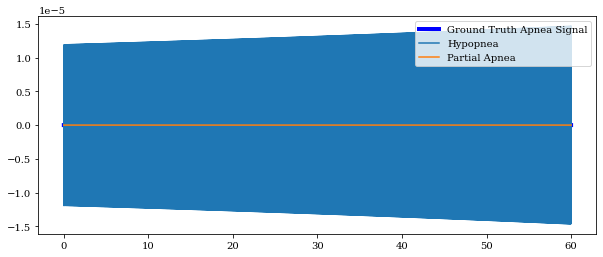

In [8]:
idx = 71
plt.figure(figsize=(10, 4))
plt.plot(t_arr, fused_dataset_train[idx]["gt_apnea"][:,0], color='blue', linewidth=4, label='Ground Truth Apnea Signal')
plt.plot(t_arr, fused_dataset_train[idx]["hypopnea"][:,0], label='Hypopnea')
plt.plot(t_arr, fused_dataset_train[idx]["partial_apnea"][:,0], label='Partial Apnea')
plt.legend()

In [10]:
root = r"E:\OSA_project\Emir_Clean\pre_load_data"
gt_apnea = np.load(os.path.join(root, "gt_apnea.npy"))
thermal_arr = np.load(os.path.join(root, "thermal_arr.npy"))
thermal_vid_arr = np.load(os.path.join(root, "thermal_vid_arr.npy"))
t_arr = np.linspace(0, 1800/30, 1800)

In [12]:
root = r"E:\OSA_project\Emir_Clean\saved_idx_arrs"
NUKS_idx = np.load(os.path.join(root, "NUKS_idx.npy"))
mode_lock_idx = np.load(os.path.join(root, "mode_lock_idx.npy"))
combined_movement_idx = np.load(os.path.join(root, "combined_movement_idx.npy"))
movement_idx = np.load(os.path.join(root, "gt_movement_idx.npy"))
discard_idx = np.load(os.path.join(root, "discard_idx.npy"))

In [14]:
full_arr = []
prod_arr = []

th_arr = np.linspace(0.1, 0.4, 15)
window_size_arr = np.linspace(20,40, 10, dtype=int)
modes = ['90th', 'max', 'median', 'mean']
percentile = 50
t_arr = np.linspace(0, 1800/30, 1800)

for th in tqdm(th_arr):
    for window_max in tqdm(window_size_arr):
        for window_min in window_size_arr:
            for mode in modes:
                gt_arr = []
                pred_arr = []
                

                for idx in np.linspace(0,len(fused_dataset_train)-1,len(fused_dataset_train), dtype=int):
                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in discard_idx)):
                        pred = utils.predict(thermal_arr[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, percentage=percentile, plot=False)

                        gt = gt_apnea[idx]
                        # gt_hp = gt_hypopnea[idx]

                        if((np.mean(gt) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        
                        if(np.mean(pred) > 0.1):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)
                        
                        # if(gt_arr[-1] != pred_arr[-1]):
                        #     print(idx)
                
                        # AHI_arr.append(np.sum(pred_arr) / (1/60))
                        # gt_AHI_arr.append(np.sum(gt_arr) / (1/60))

                precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
                # print("Precision: ", precision, "Recall: ", recall, "Accuracy: ", accuracy, "Confusion Matrix: ", confusion_matrix)
                
                prod_arr.append(precision*recall)
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))

  0%|          | 0/15 [00:00<?, ?it/s]e:\OSA_project\Emir_Clean\utils.py:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
100%|██████████| 15/15 [3:35:37<00:00, 862.49s/it]


In [15]:
# if array contains nan set that entry to zero
for i in range(len(prod_arr)):
    if(math.isnan(prod_arr[i])):
        prod_arr[i] = 0

In [17]:
best_idx = np.argsort(prod_arr)[::-1]
best_idx = np.array(best_idx, dtype=int)

In [26]:
prod_arr[best_idx[0]]

0.7259005145797598

In [44]:
np.save(r"E:\OSA_project\Emir_Clean\saved_files\prod_arr.npy", np.array(prod_arr))
import pickle
with open(r"E:\OSA_project\Emir_Clean\saved_files\full_arr.pickle", "wb") as fp:   #Pickling
    pickle.dump(full_arr, fp)

# with open("test", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

In [32]:
print(full_arr[best_idx[0]])

(0.37857142857142867, 'mean', 40, 37, 0.8363636363636363, 0.8679245283018868, 0.9728353140916808, array([[ 46,   9],
       [  7, 527]]))


In [332]:
# gt_apnea = np.zeros((len(fused_dataset_train), 1800))
# thermal_arr = np.zeros((len(fused_dataset_train), 1800))
# gt_hypopnea = np.zeros((len(fused_dataset_train), 1800))
# thermal_vid_arr = np.zeros((len(fused_dataset_train), 1800, 64, 64))
# radar_arr = np.zeros((len(fused_dataset_train), 1800, 3, 4, 2, 5))
# gt_radar_arr = np.zeros((len(fused_dataset_train), 1800))
# gt_ir_arr = np.zeros((len(fused_dataset_train), 1800))

# for i in tqdm(range(len(fused_dataset_train))):
#     radar_arr[i,:,:,:,:,:] = fused_dataset_train[i]['radar']
#     gt_radar_arr[i,:] = fused_dataset_train[i]['gt_radar'][:,0]
#     gt_ir_arr[i,:] = fused_dataset_train[i]['gt_ir'][:,0]
#     thermal_vid_arr[i,:,:,:] = fused_dataset_train[i]['thermal'][0,:]
#     gt_hypopnea[i,:] = fused_dataset_train[i]["hypopnea"][:,0]
#     gt_apnea[i,:] = fused_dataset_train[i]["gt_apnea"][:,0]

#     thermal = utils.get_thermal(fused_dataset_train[i])
#     thermal = (thermal - np.mean(thermal))/np.std(thermal)
#     thermal_arr[i,:] = thermal
    
# np.save(r"E:\OSA_project\Emir_Clean\gt_apnea.npy", gt_apnea)
# np.save(r"E:\OSA_project\Emir_Clean\thermal_arr.npy", thermal_arr)
# np.save(r"E:\OSA_project\Emir_Clean\thermal_vid_arr.npy", thermal_vid_arr)
# np.save(r"E:\OSA_project\Emir_Clean\gt_hypopnea.npy", gt_hypopnea)
# np.save(r"E:\OSA_project\Emir_Clean\radar_arr.npy", radar_arr)
# np.save(r"E:\OSA_project\Emir_Clean\gt_radar_arr.npy", gt_radar_arr)
# np.save(r"E:\OSA_project\Emir_Clean\gt_ir_arr.npy", gt_ir_arr)

In [48]:
good_data_idx = [602,617,642,653,655,656]
not_detected_movement = [328,331,846,855,859]

In [90]:
percentile = 50
t_arr = np.linspace(0, 1800/30, 1800)

gt_arr = []
pred_arr = []

for idx in np.linspace(0,len(fused_dataset_train)-1,len(fused_dataset_train), dtype=int):
    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and ((idx not in movement_old) or (idx in apnea_idx)) and ((idx not in wrong_idx) or (idx in include_idx)) and (idx not in jj)):
        pred = utils.predict(thermal_arr[idx], dmin=29, dmax=31, th=0.33947368421052626, mode='mean', percentage=percentile, plot=False)

        gt = gt_apnea[idx]
        # gt_hp = gt_hypopnea[idx]

        if((np.mean(gt) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
            gt_arr.append(1)
        else:
            gt_arr.append(0)
        
        if(np.mean(pred) > 0.1):
            pred_arr.append(1)
        else:
            pred_arr.append(0)
        
        # if(gt_arr[-1] != pred_arr[-1]):
        #     print(idx)

        # AHI_arr.append(np.sum(pred_arr) / (1/60))
        # gt_AHI_arr.append(np.sum(gt_arr) / (1/60))

precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
# print("Precision: ", precision, "Recall: ", recall, "Accuracy: ", accuracy, "Confusion Matrix: ", confusion_matrix)

print(precision*recall)
print(recall, precision, accuracy, confusion_matrix)

0.7851307189542484
0.9117647058823529 0.8611111111111112 0.9735099337748344 [[ 62   6]
 [ 10 526]]


In [74]:
full_arr = []

AHI_arr = []
gt_AHI_arr = []

prod_arr = []

th_arr = np.linspace(0.2, 0.4, 15)
window_size_arr = np.linspace(20,40, 20, dtype=int)
modes = ['mean'] # ['90th', 'max', 'median', 'mean']
percentile = 50
t_arr = np.linspace(0, 1800/30, 1800)

for th in tqdm(th_arr):
    for mode in modes:
        for window_max in window_size_arr:
            for window_min in window_size_arr:
                gt_arr = []
                pred_arr = []
                

                for idx in np.linspace(0,len(fused_dataset_train)-1,len(fused_dataset_train), dtype=int):
                    if(((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in not_detected_movement)) or (idx in good_data_idx)):
                        pred = utils.predict(thermal_arr[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, percentage=percentile, plot=False)

                        gt = gt_apnea[idx]
                        # gt_hp = gt_hypopnea[idx]

                        if((np.mean(gt) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        
                        if(np.mean(pred) > 0.1):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)
                        
                        # if(gt_arr[-1] != pred_arr[-1]):
                        #     print(idx)
                
                        # AHI_arr.append(np.sum(pred_arr) / (1/60))
                        # gt_AHI_arr.append(np.sum(gt_arr) / (1/60))

                precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
                # print("Precision: ", precision, "Recall: ", recall, "Accuracy: ", accuracy, "Confusion Matrix: ", confusion_matrix)
                
                prod_arr.append(precision*recall)
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))

100%|██████████| 15/15 [3:30:18<00:00, 841.21s/it]  


In [77]:
prod = np.array(prod_arr)

# if array contains nan set that entry to zero
for i in range(len(prod)):
    if(math.isnan(prod[i])):
        prod[i] = 0

best_idx = np.argsort(prod)[::-1]
best_idx = np.array(best_idx, dtype=int)

In [81]:
print(prod[best_idx[0]])
print(full_arr[best_idx[0]])

0.7250980392156863
(0.37142857142857144, 'mean', 38, 36, 0.8431372549019608, 0.86, 0.9738219895287958, array([[ 43,   8],
       [  7, 515]]))


In [89]:
jj = [
    62,
    71,
    74,
    78,
    79,
    207,
    211,
    214,
    223,
    229,
    231,
    287,
    296,
    300,
    324,
    328,
    331,
    338,
    60,
    64,
    69,
    74,
    75,
    200,
    201,
    203,
    206,
    225,
    234,
    239]

wrong_idx = [
            62,
            71,
            78,
            79,
            207,
            211,
            214,
            223,
            229,
            231,
            241,
            242,
            244,
            250,
            251,
            253,
            255,
            460,
            465,
            478,
            483,
            590,
            591,
            596,
            598,
            612,
            654,
            684,
            773,
            841,
            842,
            843,
            846,
            855,
            856,
            857,
            858,
            859,
            988]

include_idx = [241,
                242,
                244,
                250,
                251,
                253,
                255,
                460,
                465,
                478,
                590,
                596,
                612,
                654,
                684,
                773]

In [ ]:
for idx in apnea_idx:
    plt.figure(figsize=(12, 12))
    pred = utils.predict(thermal_arr[idx], dmin=20, dmax=30, th=0.2, mode='90th', plot=True)
    plt.plot(t_arr, fused_dataset_train[idx]["gt_apnea"][:,0], color='blue', linewidth=4, label='Ground Truth Apnea Signal')
    plt.plot(t_arr, fused_dataset_train[idx]["hypopnea"][:,0], label='Hypopnea')
    plt.plot(t_arr, fused_dataset_train[idx]["partial_apnea"][:,0], label='Partial Apnea')
    
    plt.legend()
    plt.show()

In [ ]:
movement_new_idx = []
for idx in tqdm(range(len(fused_dataset_train))):
    thermal = thermal_arr[idx]

    lmin, lmax = utils.hl_envelopes_idx(thermal, dmin=29, dmax=31)

    # lx = np.linspace(0, len(thermal)/30, len(thermal))[lmin]
    # mx = np.linspace(0, len(thermal)/30, len(thermal))[lmax]
    min_env = thermal[lmin]
    max_env = thermal[lmax]
    # dists_min, dists_max = utils.get_motion_scores(min_env, max_env, half_len=2)
    half_len = 4 

    dists_min = []
    dists_max = []
    # start_vec = [(max_env[0]-max_env[1+i])**2 for i in range(half_len)]
    # start_vec = np.array(start_vec)
    # dists_max = [np.sum(start_vec)/((1 or np.median(start_vec[np.argsort(start_vec)[::-1]]))*len(start_vec))]

    for i in range(1, len(max_env)-1):
        vec_start = max(0, i - half_len)
        vec_end = min(len(max_env), i + half_len)
        vec = max_env[vec_start:vec_end]
        vec = np.array(vec)
        center_vec = np.repeat(max_env[i], len(vec))
        dist = np.sum((center_vec - vec)**2)/((1 or np.median(vec[np.argsort(vec)[::-1]]))*len(vec))
        dists_max.append(dist)

    # end_vec = [(max_env[len(max_env)-1]-max_env[len(max_env)-2-i])**2  for i in range(half_len)]
    # end_vec = np.array(end_vec)
    # dists_max.append(np.sum(end_vec)/((1 or np.median(end_vec[np.argsort(end_vec)[::-1]]))*len(end_vec)))


    # start_vec = [(min_env[0]-min_env[1+i])**2 for i in range(half_len)]
    # start_vec= np.array(start_vec)
    # dists_min = [np.sum(start_vec)/((1 or np.median(start_vec[np.argsort(start_vec)[::-1]]))*len(start_vec))]

    for i in range(1, len(min_env)-1):
        vec_start = max(0, i - half_len)
        vec_end = min(len(min_env), i + half_len)
        vec = min_env[vec_start:vec_end]
        vec = np.array(vec)
        center_vec = np.repeat(min_env[i], len(vec))
        dist = np.sum((center_vec - vec)**2)/((1 or np.median(vec[np.argsort(vec)[::-1]]))*len(vec))
        dists_min.append(dist)

    # end_vec = [(min_env[len(min_env)-1]-min_env[len(min_env)-2-i])**2  for i in range(half_len)]
    # end_vec = np.array(end_vec)
    # dists_min.append(np.sum(end_vec)/((1 or np.median(end_vec[np.argsort(end_vec)[::-1]]))*len(end_vec)))
    
    # plt.plot(t_arr, thermal)
    # plt.plot(t_arr[lmin], min_env)
    # plt.plot(t_arr[lmax], max_env)
    # plt.show()

    dists_min = np.array(dists_min)
    dists_max = np.array(dists_max)

    # plt.plot(t_arr[lmin][1:-1], dists_min)
    # plt.show()

    # plt.plot(t_arr[lmax][1:-1], dists_max)
    # break

    ld, ud = max(dists_min), max(dists_max)
    if((ld > 4.5) or (ud > 4.5)):
        movement_new_idx.append(idx)

In [ ]:
len(movement_new_idx)

In [ ]:
len(movement_idx)

In [ ]:
for idx in range(len(thermal_arr)):
    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and ((idx not in movement_idx) or (idx in apnea_idx)) and ((idx not in wrong_idx) or (idx not in include_idx))): 
        thermal = thermal_arr[idx]
        print(idx)
        plt.plot(t_arr, thermal)
        plt.show()

In [ ]:
# Th: 0.35555556, Mode: mean, Window Size: 26 --> best result so far

In [15]:
full_arr = []
recall_arr = []
accuracy_arr = []
precision_arr = []
confusion_arr = []

AHI_arr = []
gt_AHI_arr = []

prod_arr = []
param_arr = []


th_arr = np.linspace(0.1, 0.9, 40)
window_size_arr = np.linspace(20,50, 30, dtype=int)
modes = ['mean'] # ['90th', 'max', 'median', 'mean']
percentile = 50
t_arr = np.linspace(0, 1800/30, 1800)

for th in tqdm(th_arr):
    for mode in modes:
        for window_max in window_size_arr:
            for window_min in window_size_arr:
                gt_arr = []
                pred_arr = []
                

                for idx in np.linspace(0,len(fused_dataset_train)-1,len(fused_dataset_train), dtype=int):
                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and ((idx not in movement_idx) or (idx in apnea_idx)) and ((idx not in wrong_idx) or (idx in include_idx)) and (idx not in jj)):
                        pred = utils.predict(thermal_arr[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, percentage=percentile, plot=False)

                        gt = gt_apnea[idx]
                        # gt_hp = gt_hypopnea[idx]

                        if((np.mean(gt) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        
                        if(np.mean(pred) > 0.1):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)
                        
                        # if(gt_arr[-1] != pred_arr[-1]):
                        #     print(idx)
                
                        AHI_arr.append(np.sum(pred_arr) / (1/60))
                        gt_AHI_arr.append(np.sum(gt_arr) / (1/60))

                precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
                # recall_arr.append(recall)
                # accuracy_arr.append(accuracy)
                # precision_arr.append(precision)
                # confusion_arr.append(confusion_matrix)
                
                prod_arr.append(precision*recall)
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))

                # print(f"Th: {th}, Mode: {mode}, Window Size: {window_size}")
                # print(f"Recall: {recall}, Precision: {precision}, Accuracy: {accuracy}")
                # print(confusion_matrix)


100%|██████████| 40/40 [22:58:23<00:00, 2067.59s/it]   


In [16]:
np.save(r"E:\OSA_project\Emir_Clean\full_arr.npy", full_arr)
# np.save(r"E:\OSA_project\Emir_Clean\recall_arr.npy", recall_arr)
# np.save(r"E:\OSA_project\Emir_Clean\accuracy_arr.npy", accuracy_arr)
# np.save(r"E:\OSA_project\Emir_Clean\precision_arr.npy", precision_arr)
# np.save(r"E:\OSA_project\Emir_Clean\confusion_arr.npy", confusion_arr)
# np.save(r"E:\OSA_project\Emir_Clean\AHI_arr.npy", AHI_arr)

# np.save(r"E:\OSA_project\Emir_Clean\gt_AHI_arr.npy", gt_AHI_arr)
np.save(r"E:\OSA_project\Emir_Clean\prod_arr.npy", prod_arr)

C:\Users\111\AppData\Roaming\Python\Python38\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
import pickle
with open(r"E:\OSA_project\Emir_Clean\full_arr.pickle", "wb") as fp:   #Pickling
    pickle.dump(full_arr, fp)

# with open("test", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

In [ ]:
for i in range(len(wrong_idx)):
    print(wrong_idx[i])
    plt.plot(t_arr, thermal_arr[wrong_idx[i]])
    plt.show()

In [ ]:
np.save(r"E:\OSA_project\Emir_Clean\gt_apnea.npy", gt_apnea)
np.save(r"E:\OSA_project\Emir_Clean\thermal_arr.npy", thermal_arr)

In [315]:
prod = np.array(precision_arr)*np.array(recall_arr)

# if array contains nan set that entry to zero
for i in range(len(prod)):
    if(math.isnan(prod[i])):
        prod[i] = 0

In [17]:
best_idx = np.argsort(prod_arr)[::-1]

In [29]:
best_idx = np.array(best_idx, dtype=int)

In [31]:
print(prod_arr[best_idx[0]])
# print(full_arr[best_idx[0]])

0.7851307189542484


In [54]:
full_arr[best_idx[10]]

(0.3666666666666667,
 'mean',
 28,
 37,
 0.9117647058823529,
 0.8611111111111112,
 0.9735099337748344,
 array([[ 62,   6],
        [ 10, 526]]))

In [34]:
print(prod_arr[best_idx[0:10]])

TypeError: only integer scalar arrays can be converted to a scalar index

In [330]:
precision_arr[16], recall_arr[16], accuracy_arr[16], confusion_arr[16]

(0.7272727272727273,
 0.7698744769874477,
 0.7947019867549668,
 array([[184,  55],
        [ 69, 296]]))

In [32]:
precision_arr[best_idx[0]], recall_arr[best_idx[0]], accuracy_arr[best_idx[0]], confusion_arr[best_idx[0]]

IndexError: list index out of range

In [328]:
np.argmin((np.array(AHI_arr) - np.array(gt_AHI_arr))**2)

16

In [329]:
AHI_arr[16], gt_AHI_arr[0]

(25.132450331125828, 23.741721854304636)

In [ ]:
th_arr[10], modes[3], window_size_arr[7], window_size_arr[6]
# (0.33947368421052626, 'mean', dmax 31, dmin 29)

In [ ]:
((best_idx[0] % (20*20*4)) % (20*20)) % 20


In [ ]:
np.save(r"E:\OSA_project\Emir_Clean\th_arr.npy", th_arr)
np.save(r"E:\OSA_project\Emir_Clean\window_size_arr.npy", window_size_arr)
np.save(r"E:\OSA_project\Emir_Clean\modes.npy", modes)
np.save(r"E:\OSA_project\Emir_Clean\recall_arr.npy", recall_arr)
np.save(r"E:\OSA_project\Emir_Clean\accuracy_arr.npy", accuracy_arr)
np.save(r"E:\OSA_project\Emir_Clean\precision_arr.npy", precision_arr)
np.save(r"E:\OSA_project\Emir_Clean\confusion_arr.npy", confusion_arr)

In [ ]:
plt.plot(precision_arr)
plt.show()
plt.plot(recall_arr)
plt.show()

In [ ]:
# 1.1) do a grid search to optimize params 3) threshold, 2) window size 1) normalization method for envelope difference
# 1.2) save which samples were misclassified, record their index

# 2.0) come up with hypopnea model
# 2.1) implement AHI and other relevant metrics
# 2.2) explain model shortcomings